# New York City Taxi Fare Prediction

kaggleで実施されていた、ニューヨークのタクシー料金を、乗降場所、日時などのデータから予測するモデルを作る課題です。　　
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data?select=test.csv

# ライブラリをインポート

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib

import warnings
warnings.filterwarnings("ignore")

# データセットの読み込み

In [2]:
df_train = pd.read_csv('train-002.csv', nrows=1000000)
df_test  = pd.read_csv('test-002.csv')

In [3]:
display(df_train.head())
print()
display(df_train.info())
print()
display(df_train.describe())

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


None

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


# 欠損値処理

In [4]:
# 欠損値を確認する
df_train.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

欠損行は少ないため、行ごと削除する

In [5]:
# 欠損がある行を削除する
df_train = df_train.dropna()
df_train.shape

(999990, 8)

In [6]:
# 欠損値を確認する
df_train.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

# 外れ値処理

In [7]:
display(df_train.describe())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.347953,-72.526699,39.929040,-72.527860,39.919954,1.684941
std,9.821790,12.057778,7.626087,11.324494,8.201418,1.323907
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


fare_amount = -44.9　、pickup_longitude =-3377.680935など、明らかにおおかしい値を取り除く

In [8]:
# fare_amount を0以上にする
df_train = df_train[df_train['fare_amount'] > 0]
df_train.shape

(999923, 8)

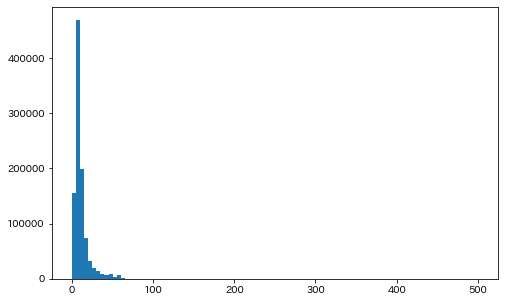

In [9]:
# 分布を確認
plt.figure(figsize=(8,5))
plt.hist(df_train['fare_amount'], bins=100)
plt.show()

500ドル近いものが少数存在するが、100ドル以下に絞ってみる

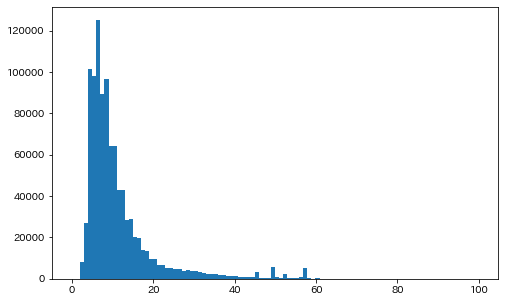

In [10]:
# 100ドル以下に絞る
df_train = df_train[df_train['fare_amount'] < 100]

plt.figure(figsize=(8,5))
plt.hist(df_train['fare_amount'], bins=100)
plt.show()

まだ60〜100ドルで外れ値がありそうである

## 四分位偏差を使った処理

In [11]:
def outlier_iqr(df, columns=None):
    if columns == None:
        columns = df.columns
        
    for col in columns:
        q1 = df[col].describe()['25%']
        q3 = df[col].describe()['75%']
        # 四分位範囲
        iqr = q3 - q1

        outlier_min = q1 - iqr * 1.5
        outlier_max = q3 + iqr * 1.5

    # 範囲から外れている値を除く
        df = df[(df[col] >= outlier_min) & (df[col] <= outlier_max)]
  
    return df

In [12]:
print('before',df_train.shape)
df_train = outlier_iqr(df_train, columns=['fare_amount'])
print('after',df_train.shape)

before (999488, 8)
after (913433, 8)


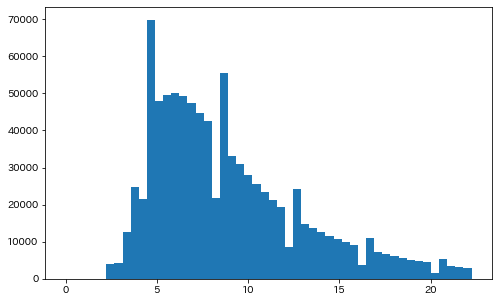

In [13]:
plt.figure(figsize=(8,5))
plt.hist(df_train['fare_amount'], bins=50)
plt.show()

ニューヨークのlongitudeは-74度なので、−74±１にする

In [14]:
print('before',df_train.shape)
df_train = df_train[(df_train['pickup_longitude'] > -75) & (df_train['pickup_longitude'] < -73)]
df_train = df_train[(df_train['dropoff_longitude'] > -75) & (df_train['dropoff_longitude'] < -73)]
print('after',df_train.shape)

before (913433, 8)
after (894994, 8)


In [15]:
df_train['passenger_count'].value_counts()

1    620241
2    131277
5     63190
3     39142
4     19129
6     18634
0      3381
Name: passenger_count, dtype: int64

乗客数が0人はおかしいので、passenger_countを1以上にする

In [31]:
print('before',df_train.shape)
df_train = df_train[(df_train['passenger_count'] > 0)]
print('after',df_train.shape)

before (891613, 12)
after (891613, 12)


In [32]:
#再度確認
display(df_train.describe())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,dayofweek,year
count,891613.000000,891613.000000,891613.000000,891613.000000,891613.000000,891613.000000,891613.000000,891613.000000,891613.000000,891613.000000
mean,8.936848,-73.979697,40.753505,-73.978055,40.752889,1.687381,13.548713,15.689665,3.041294,2011.701216
std,4.138309,0.028308,0.979376,0.028408,0.801126,1.303787,6.505053,8.684701,1.946559,1.862069
min,0.010000,-74.972872,0.000000,-74.981562,0.000262,1.000000,0.000000,1.000000,0.000000,2009.000000
25%,5.700000,-73.992556,40.737289,-73.991856,40.737123,1.000000,9.000000,8.000000,1.000000,2010.000000
50%,8.000000,-73.982436,40.753337,-73.981316,40.753984,1.000000,14.000000,16.000000,3.000000,2012.000000
75%,11.000000,-73.970197,40.766925,-73.967945,40.767962,2.000000,19.000000,23.000000,5.000000,2013.000000
max,22.250000,-73.036247,424.083332,-73.029770,405.650000,6.000000,23.000000,31.000000,6.000000,2015.000000


# 5.特徴量エンジニアリング

日時

In [33]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,dayofweek,year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,15,0,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,3,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,21,5,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,1,2010


In [34]:
df_train['hour'] = df_train['pickup_datetime'].dt.hour
df_train['day'] = df_train['pickup_datetime'].dt.day
df_train['dayofweek'] = df_train['pickup_datetime'].dt.dayofweek
df_train['year'] = df_train['pickup_datetime'].dt.year

df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,dayofweek,year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,15,0,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,3,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,21,5,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,1,2010


# 標準化

In [35]:
train_dec = df_train.drop(columns=['key', 'fare_amount', 'pickup_datetime'], axis=1)
train_dec.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,dayofweek,year
0,-73.844311,40.721319,-73.841610,40.712278,1,17,15,0,2009
1,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010
2,-73.982738,40.761270,-73.991242,40.750562,2,0,18,3,2011
3,-73.987130,40.733143,-73.991567,40.758092,1,4,21,5,2012
4,-73.968095,40.768008,-73.956655,40.783762,1,7,9,1,2010


In [36]:
# 標準化
from sklearn.preprocessing import StandardScaler
num_features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'hour', 'day', 'dayofweek', 'year',
                               'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
for col in num_features:
    scaler = StandardScaler()
    train_dec[col] = scaler.fit_transform(np.array(train_dec[col].values).reshape(-1,1))

train_dec.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,dayofweek,year
0,4.782533,-0.032863,4.803075,-0.050692,1,0.530555,-0.079411,-1.562396,-1.450654
1,-1.284119,-0.043090,-0.042699,0.036343,1,0.376828,-1.230862,-1.048668,-0.913617
2,-0.107435,0.007929,-0.464202,-0.002905,2,-2.082800,0.266024,-0.021214,-0.376579
3,-0.262584,-0.020790,-0.475643,0.006495,1,-1.467893,0.611459,1.006241,0.160458
4,0.409832,0.014809,0.753313,0.038537,1,-1.006712,-0.770282,-1.048668,-0.913617


# 主成分分析

In [22]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(train_dec)
X_pca.shape

(891613, 9)

In [23]:
pca.explained_variance_ratio_

array([0.17652214, 0.17209509, 0.11236838, 0.10413943, 0.10307058,
       0.10301944, 0.10204122, 0.09326443, 0.03347931])

In [24]:
pca.explained_variance_ratio_.cumsum()

array([0.17652214, 0.34861723, 0.46098561, 0.56512503, 0.66819561,
       0.77121505, 0.87325627, 0.96652069, 1.        ])

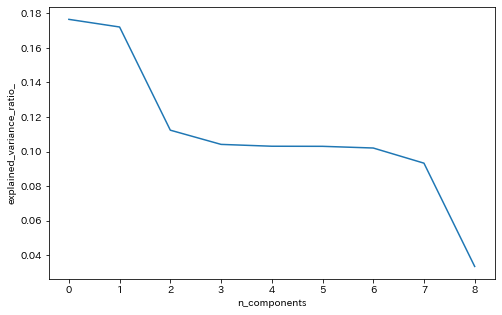

In [25]:
%matplotlib inline
plt.figure(figsize=(8,5))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.show()

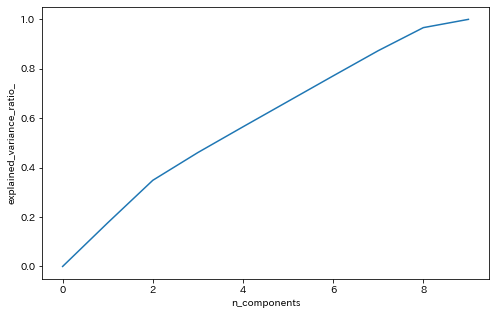

In [26]:
%matplotlib inline
plt.figure(figsize=(8,5))
plt.plot(np.hstack([0, pca.explained_variance_ratio_.cumsum()]))
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.show()

<Figure size 1440x720 with 0 Axes>

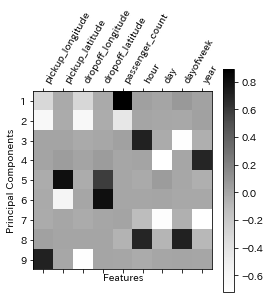

In [27]:
plt.figure(figsize=(20,10))
plt.matshow(pca.components_, cmap='Greys')
plt.yticks(range(len(pca.components_)), range(1, len(pca.components_)+1))
plt.colorbar()
plt.xticks(range(train_dec.shape[1]), train_dec.columns.values, rotation=60, ha='left')
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.show()

# xgboost

In [28]:
# cross validation
from sklearn.model_selection import train_test_split

In [29]:
# xgboost
import xgboost as xgb

In [37]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,dayofweek,year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,15,0,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,3,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,21,5,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,1,2010


In [40]:
X = df_train.drop(columns=['key', 'fare_amount','pickup_datetime'])
y = df_train['fare_amount']

print(X.shape)
print(y.shape)

(891613, 9)
(891613,)


In [42]:
# 訓練データとテストデータに分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape)
print(X_test.shape)

(668709, 9)
(222904, 9)


In [47]:
# パラメーター
params = {
    'silent': 1,
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': 0.1,
    'tree_method': 'exact',
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'predictor': 'cpu_predictor'
}



dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=5000,
                  early_stopping_rounds=5,
                  evals=[(dtest, 'test')])

[21:52:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:52:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	test-rmse:8.59411
[1]	test-rmse:7.88470
[2]	test-rmse:7.24828
[3]	test-rmse:6.69683
[4]	test-rmse:6.19530
[5]	test-rmse:5.75816
[6]	test-rmse:5.37665
[7]	test-rmse:5.04027
[8]	test-rmse:4.73894
[9]	test-rmse:4.46800
[10]	test-rmse:4.23836
[11]	test-rmse:4.04060
[12]	test-rmse:3.85926
[13]	test-rmse:3.71315
[14]	test-rmse:3.57310
[1

# Feature importance

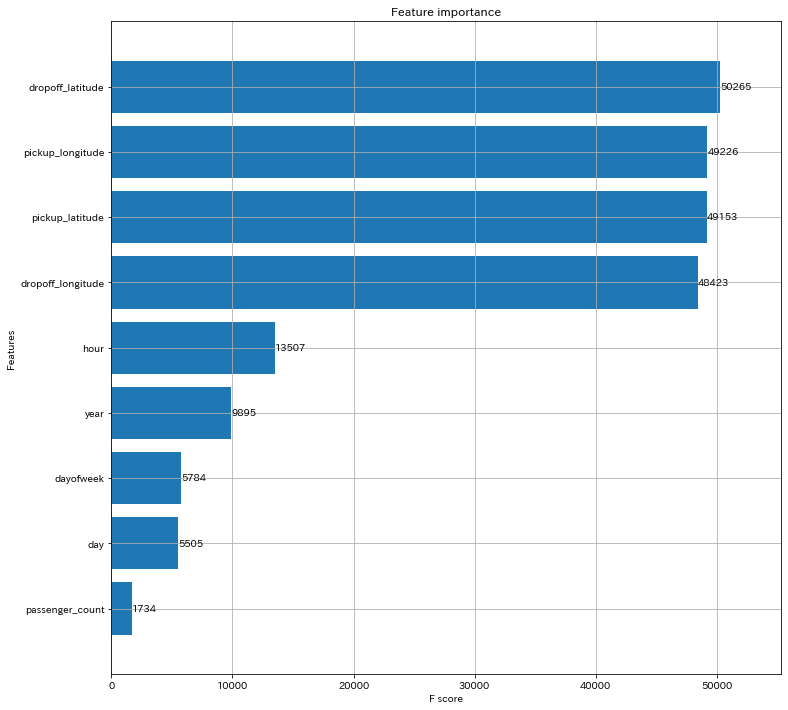

In [50]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=12, height=0.8, ax=ax)
plt.show()